In [1]:
import warnings
import numpy as np

from importlib import reload

import wandb

from context import omphalos

# Import Omphalos modules.
from omphalos import generate_inputs as gi
from omphalos import file_methods as fm
from omphalos import my_metrics as mm
from omphalos import omphalos_plotter as op
from omphalos import attributes as attr
from omphalos import labels as lbls
from omphalos import spatial_constructor

from matplotlib import pyplot as plt

%matplotlib inline
%precision 4

'%.4f'

In [2]:
%%time

np.random.seed(0)

train_set = fm.unpickle('data/old_rifle.pkl')


attributes_df = attr.boundary_condition(train_set, boundary='x_begin')
labels_df = lbls.secondary_precip(train_set)

x = attributes_df.loc[:, ['NH4+', 'SO4--','Ca++', 'Acetate', 'CO2(aq)']]
y = labels_df.sum(level=0)['FeS(am)'] + labels_df.sum(level=0)['FeS34(am)']

x = x.to_numpy()
y = y.to_numpy().reshape(-1,1)
y = y * 1e4


from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

import xgboost as xgb

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

CPU times: user 2min 59s, sys: 32.3 s, total: 3min 31s
Wall time: 3min 35s


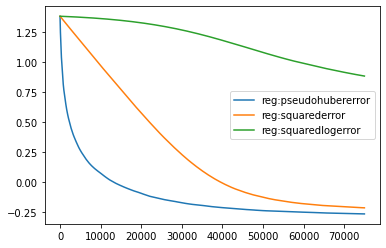

CPU times: user 1h 57min 27s, sys: 3min 24s, total: 2h 52s
Wall time: 19min 44s


In [9]:
%%time

def train_booster(ax, objective):

    evallist = [(dtest, 'eval'), (dtrain, 'train')]
    param = {'max_depth': 6, 'eta': 0.0001, 'objective': objective, 'alpha': 1, 'lambda': 1, 'eval_metric': 'rmse'}
    results = {}
    num_round = 75000
    bst = xgb.train(param, dtrain, num_round, evallist, evals_result=results, early_stopping_rounds=500, verbose_eval=False,)
    return results

objective_list = {'reg:pseudohubererror': ['rmse', 'Pseudo-Huber loss'],
                'reg:squarederror': ['rmse', 'Squared loss'],
                'reg:squaredlogerror': ['rmse', 'Squared log-loss']
                }

results_dict = {}

for objective in objective_list:
    results = train_booster(ax, objective)
    results_dict.update({objective: results})
    





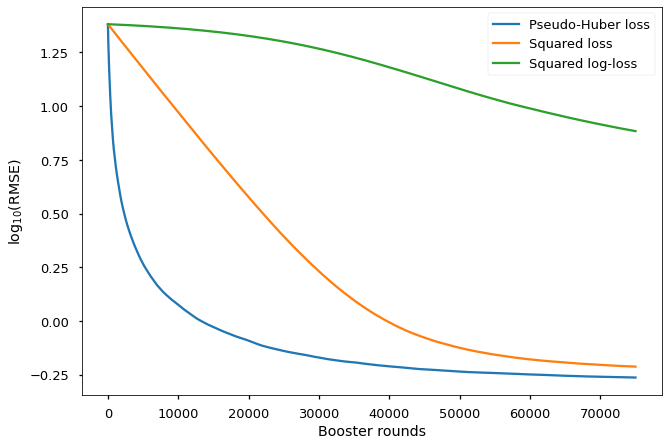

In [34]:
from matplotlib import pyplot as plt

plt.style.use('seaborn-talk')

objective_list = {'reg:pseudohubererror': ['rmse', 'Pseudo-Huber loss'],
                'reg:squarederror': ['rmse', 'Squared loss'],
                'reg:squaredlogerror': ['rmse', 'Squared log-loss']
                }

fig, ax = plt.subplots()

for objective in objective_list:
    history = results_dict[objective]['eval']['rmse']
    ax.plot(range(0, len(history)), np.log10(history), label=objective_list[objective][1])

    
ax.set_ylabel('log$_{10}$(RMSE)')
ax.set_xlabel('Booster rounds')
ax.legend()
fig.savefig('/Users/angus/Dropbox/ompahlos_paper/figures/loss_comparision.png', dpi=300)

In [30]:
bst.save_model('model.json')

NameError: name 'bst' is not defined

In [5]:
ypred = bst.predict(dtest)

from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, ypred))
rmse

8.768552908023505

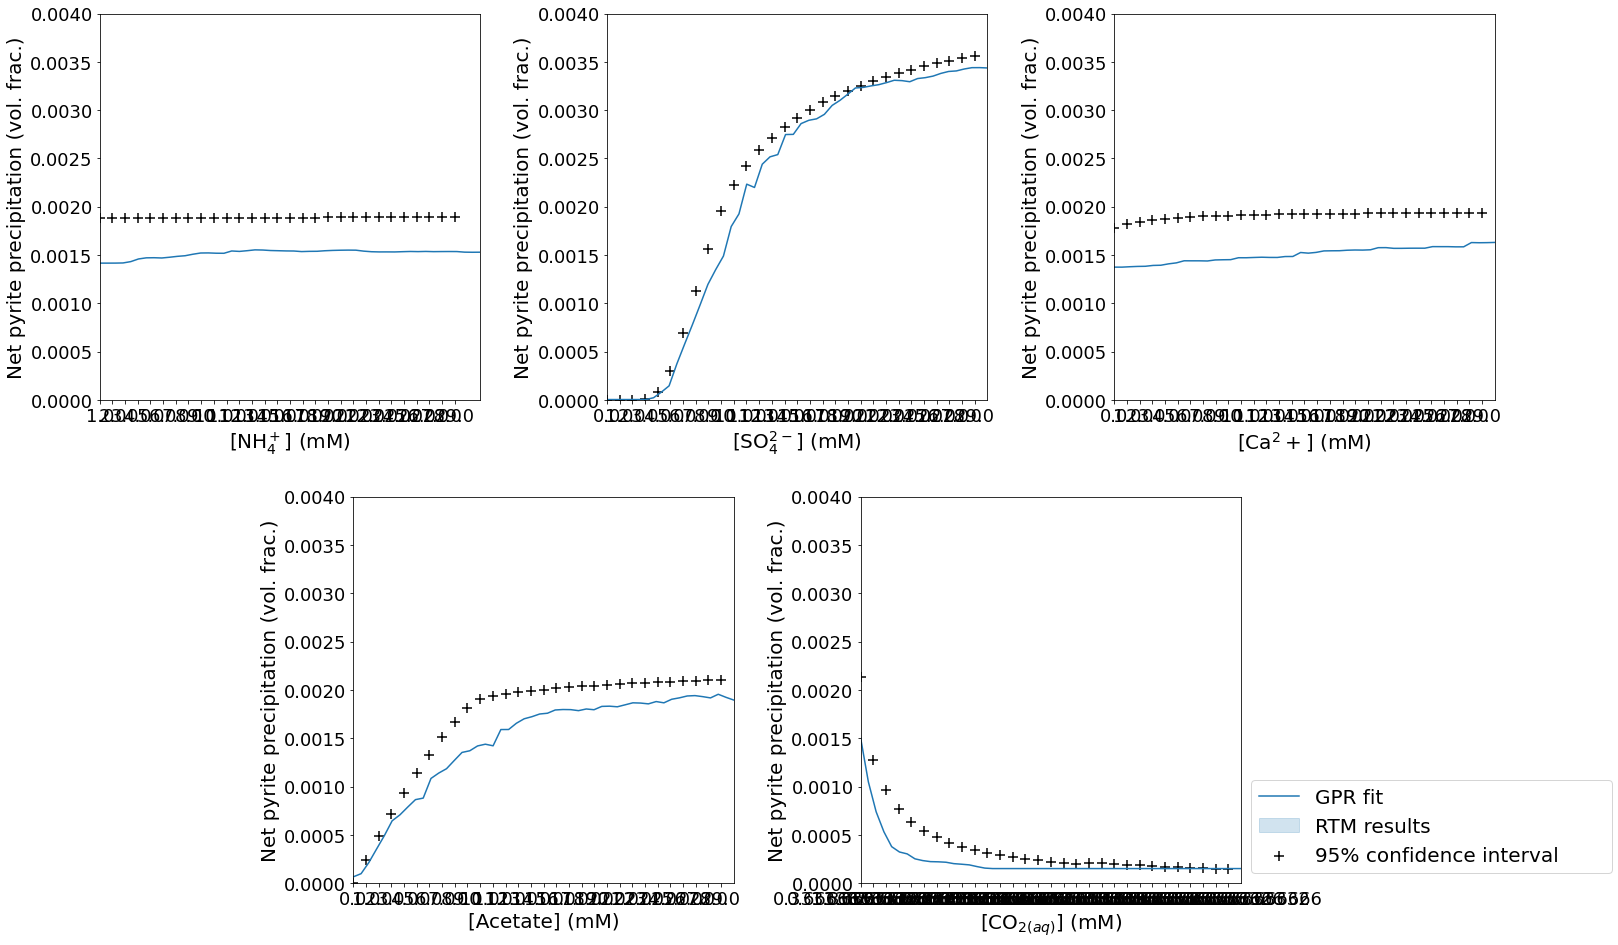

In [6]:
import gpflow_plotting as gpfp
from importlib import reload  
reload(gpfp)

# Make figure and layout.

fig = plt.figure(figsize=(25, 16))

plt.subplots_adjust(wspace=1, hspace=0.25)

# Generate uneven subplots
sub1 = fig.add_subplot(2,6,(1,2))
sub2 = fig.add_subplot(2,6,(3,4))
sub3 = fig.add_subplot(2,6,(5,6))
sub4 = fig.add_subplot(2,6,(8,9))
sub5 = fig.add_subplot(2,6,(10,11))

axis_list = [sub1, sub2, sub3, sub4, sub5]


species_list = ['NH4+', 'SO4--','Ca++', 'Acetate', 'CO2(aq)']
axis_labels = ['[NH$_4^+$] (mM)', '[SO$_4^{2-}$] (mM)','[Ca$^2+$] (mM)', '[Acetate] (mM)', '[CO$_{2(aq)}$] (mM)']

samples = 50
dims = 5
plot_vars = np.arange(dims)

predict_range = (0,30)

defaults = np.ones((samples, dims))
# Default (Druhan 2014)
defaults[:,0] = 1.5
defaults[:,1] = 8.8
defaults[:,2] = 4.8
defaults[:,3] = 9.7
defaults[:,4] = 0.0325


for plot_var, x_label, species, ax in zip(plot_vars, axis_labels, species_list, axis_list):
    defaults = np.ones((samples, dims))
    # Default (Druhan 2014)
    defaults[:,0] = 1.5
    defaults[:,1] = 8.8
    defaults[:,2] = 4.8
    defaults[:,3] = 9.7
    defaults[:,4] = 0.0325
    path = 'data/rifle_sweeps/{}.pkl'.format(species)

    defaults[:,plot_var] =  np.linspace(predict_range[0], predict_range[1], len(defaults[:, plot_var]))
    
    ypred = bst.predict(xgb.DMatrix(defaults))


    sweep_x, sweep_y = gpfp.get_sweep(path, species, 'amendment', ('FeS(am)', 'FeS34(am)'))
    ax.plot(defaults[:, plot_var], ypred * 1e-4, label='GBTree fit')
    ax.fill_between(defaults[:, plot_var], (ypred - 2 * rmse * 1e-4), (ypred + 2 * rmse * 1e-4), color="C0", alpha=0.2, label='95% confidence interval')
    
    ax.set_xlabel(x_label, fontsize=20)
    ax.set_ylabel('Net pyrite precipitation (vol. frac.)', fontsize=20)
    ax.tick_params('both', labelsize=18)
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 0.0040)


    
    ax.scatter(sweep_x, sweep_y, c="k", marker='+', s=100,label='RTM results')
sub5.legend(('GPR fit', 'RTM results', '95% confidence interval'), fontsize=20, bbox_to_anchor=(1, 0, 1, 1), loc="lower left", mode="expand", ncol=1)

In [41]:
import gpflow_plotting as gpfp
from importlib import reload  
reload(gpfp)


sweep_x, sweep_y = gpfp.get_sweep('data/rifle_sweeps/Ca++.pkl', 'Ca++', 'amendment', ('FeS(am)', 'FeS34(am)'))

sweep_x

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29.])